In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [2]:
train=pd.read_csv('D:\\Data Science\\Loan Prediction\\Loan-Prediction\\train.csv')
test=pd.read_csv('D:\\Data Science\\Loan Prediction\\Loan-Prediction\\test.csv')
sample_submission=pd.read_csv('D:\Data Science\Loan Prediction\\Loan-Prediction\\sample_submission.csv')

# Exploratory Data Analysis

In [3]:
train.shape

(614, 13)

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


## There are some Null Values from above table

In [5]:
train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


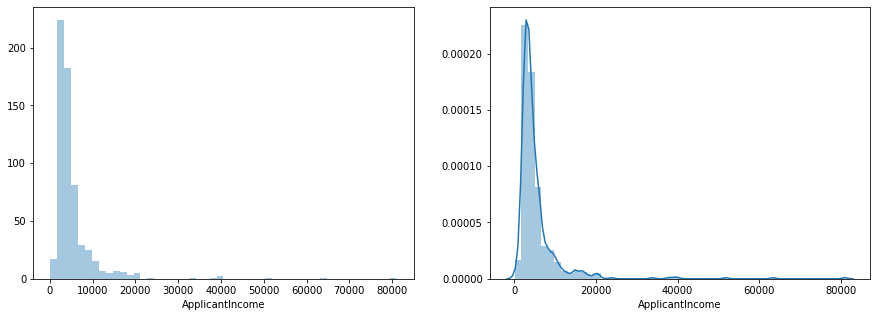

In [6]:
fig=plt.figure(figsize=(15,5))

plt.subplot2grid((1,2),(0,0))
sns.distplot(train.ApplicantIncome,kde=False)

plt.subplot2grid((1,2),(0,1))
sns.distplot(train.ApplicantIncome.dropna())

plt.show()

# The distribution is skewed and we can notice quite a few outliers.

# People with Education should have Higher Incoming Lets see how it goes

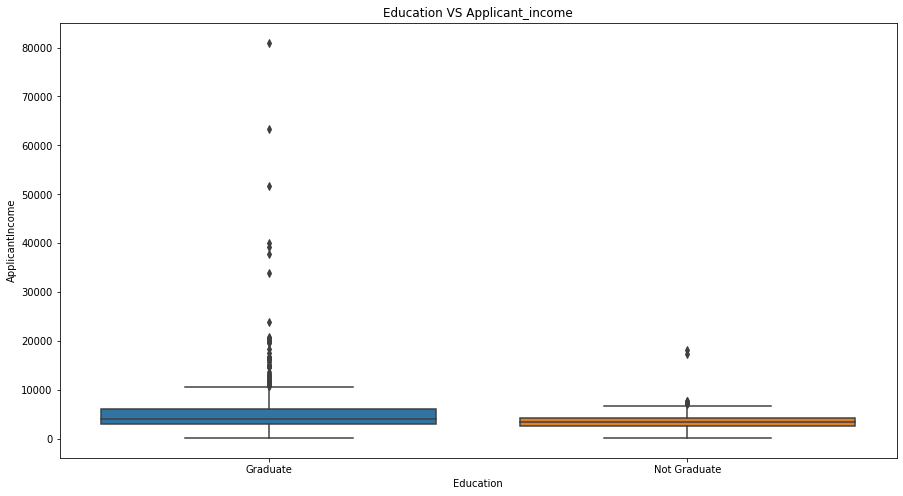

In [7]:
fig=plt.figure(figsize=(15,8))

sns.boxplot(x=train.Education, y=train.ApplicantIncome)
plt.title('Education VS Applicant_income')
plt.show()

# Graduated People have higher Salaries but there are Outliers

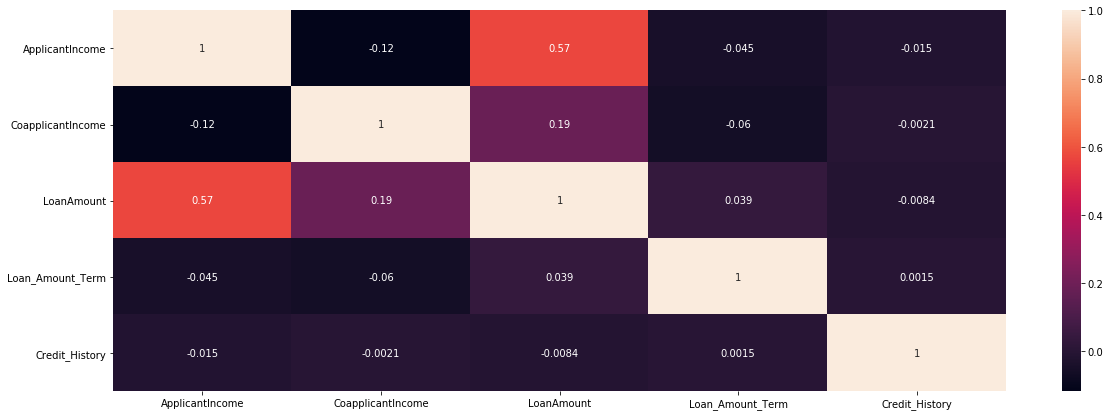

In [8]:
fig=plt.figure(figsize=(20,7))
sns.heatmap(train.corr(),annot=True)
plt.show()

#  Loan Amount and ApplicantIncome are Strongly Correlated 

# Relation between Loan_Amount and Income

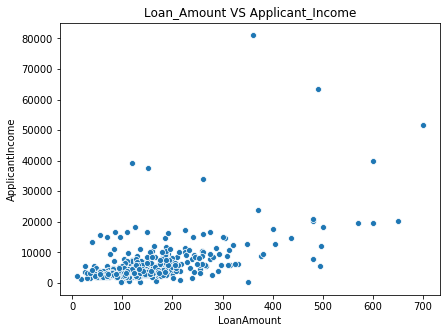

In [9]:
fig=plt.figure(figsize=(15,5))

plt.subplot2grid((1,2),(0,0))
sns.scatterplot(x=train.LoanAmount,y=train.ApplicantIncome)
plt.title('Loan_Amount VS Applicant_Income')

plt.show()

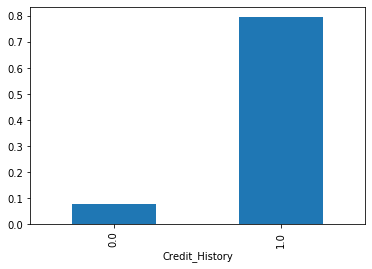

In [10]:
dummy=train
dummy['Loan_Status']=train['Loan_Status'].apply(lambda x: 0 if x=='N' else 1)
dummy.groupby('Credit_History').mean()['Loan_Status'].plot(kind='bar')
plt.show()

# People with credit history are more likely to pay their Loan.

# Data Pre-Processing

# First Check the NULL Values

In [11]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
train.Gender.fillna(train.Gender.mode()[0],inplace=True)
train.Married.fillna(train.Married.mode()[0],inplace=True)
train.Dependents.fillna(train.Dependents.mode()[0], inplace=True)
train.Loan_Amount_Term.fillna(train.Loan_Amount_Term.mode()[0], inplace=True)
train.Credit_History.fillna(train.Credit_History.mode()[0], inplace=True)
train.Self_Employed.fillna(train.Self_Employed.mode()[0],inplace=True)

In [13]:
train.Credit_History.value_counts()

1.0    525
0.0     89
Name: Credit_History, dtype: int64